# APM Project

In [21]:
#Import Statements

#basic
import pandas as pd
import numpy as np
from math import log,exp
import math

#visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn

% pylab inline

#sklearn
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor)
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import (mean_squared_error, confusion_matrix,accuracy_score, make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#MARS
import pyearth
from pyearth import Earth

#other stats & clustering
from scipy import stats
from patsy import dmatrices
from collections import Counter
from scipy.spatial.distance import cdist,pdist


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## DATA PRE-PROCESSING

In [2]:
def preprocess(df):
    
    # Feature engineering for categorical variables captured as numbers
    # Turn MSSubClass into factors
    code = ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190']
    strings = ['1-STORY 1946 & NEWER ALL STYLES', '1-STORY 1945 & OLDER', '1-STORY W/FINISHED ATTIC ALL AGES', '1-1/2 STORY - UNFINISHED ALL AGES',\
     '1-1/2 STORY FINISHED ALL AGES', '2-STORY 1946 & NEWER', '2-STORY 1945 & OLDER', '2-1/2 STORY ALL AGES', \
     'SPLIT OR MULTI-LEVEL', 'SPLIT FOYER', 'DUPLEX - ALL STYLES AND AGES', '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',\
     '1-1/2 STORY PUD - ALL AGES', '2-STORY PUD - 1946 & NEWER', 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', \
     '2 FAMILY CONVERSION - ALL STYLES AND AGES']

    MSSubClass=dict(zip(code,strings))
    df['MSSubClass']=[MSSubClass[str(val)] for val in df['MSSubClass']]

    # Turn month sold into factors
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    df['MoSold'] = df['MoSold'].replace(to_replace = df['MoSold'].value_counts().index.sort_values(),value=months)
    
    # Feature engineering for age-related variables
    # Convert yearsold vs yearbuilt into age of house
    df['Age'] =  df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', 1)
    # Convert yearsold vs. yearreomdadd into age of remodel. Adding 2 to eliminate any negative or 0 values
    df['AgeRem'] = (df['YrSold'] - df['YearRemodAdd'])+2
    df = df.drop('YearRemodAdd', 1)
    # Remove age of garage - many missing values (if no garage)
    #  no additional valuable information (garage captured in other variables); age of house more important for age
    df = df.drop('GarageYrBlt', 1)
    df = df.drop('Id',1)
    
    # Fill select variables with most common / mode where logical
    # Most masonry veneer type is None and area is 0
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
    # Most electrical is 'SBrkr'
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['LotFrontage'] = df['LotFrontage'].fillna(mean(df['LotFrontage']))
    
    return df

In [3]:
def get_dummies(X_df):
    # Dummify X data
    X_dummy = pd.get_dummies(X_df,dummy_na=True)
    return X_dummy

In [4]:
def level_cat(df_train,df_comp):
    traincols = list(df_train.columns.values)
    testcols = list(df_comp.columns.values)
    
    # Align train data columns to competition data columns
    missingcols1 = list(set(testcols)-set(traincols))
    for col in missingcols1:
        df_train[col] = 0.0

    # Align test data columns to competition data columns
    missingcols = list(set(traincols)-set(testcols))
    for col in missingcols:
        df_comp[col] = 0.0
    df_comp = df_comp[traincols+missingcols1]
    
    return df_train,df_comp

In [5]:
housedata = preprocess(pd.read_csv('train.csv'))
# Split into X and y
y = housedata['SalePrice']
X = housedata.drop('SalePrice', 1)

#preprocess and dummify competition
X = get_dummies(X)
competition = preprocess(pd.read_csv('test.csv'))
X_comp = get_dummies(competition)

X,X_comp = level_cat(X,X_comp)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=1)

## MODELING

### Initital Model Exploration (MLR, Lasso, Ridge, MLP)

In [7]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_train,y_train)
MLR_predict_reg = model_MLR.predict(X_test)
MLR_RMSE_reg= sqrt(mean_squared_error(y_test, MLR_predict_reg))
print "MLR RMSE:",MLR_RMSE_reg

#get best λ with LassoCV
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv = lasso_cv.fit(X_train,ravel(y_train))
print "Lasso CV best λ:",model_cv.alpha_
lasso_predict_reg= model_cv.predict(X_test)
lasso_RMSE_reg= sqrt(mean_squared_error(y_test, lasso_predict_reg))
print "Lasso RMSE:",lasso_RMSE_reg

#get best λ with RidgeCV
ridge_cv = RidgeCV(cv=10)
ridge_model_cv = ridge_cv.fit(X_train,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv.alpha_
ridge_predict_reg= ridge_model_cv.predict(X_test)
ridge_RMSE_reg= sqrt(mean_squared_error(y_test, ridge_predict_reg))
print "Ridge RMSE:",ridge_RMSE_reg

MLR RMSE: 35113.8209278
Lasso CV best λ: 224475.036998
Lasso RMSE: 39996.0347001
Ridge CV best λ: 10.0
Ridge RMSE: 29851.4865885


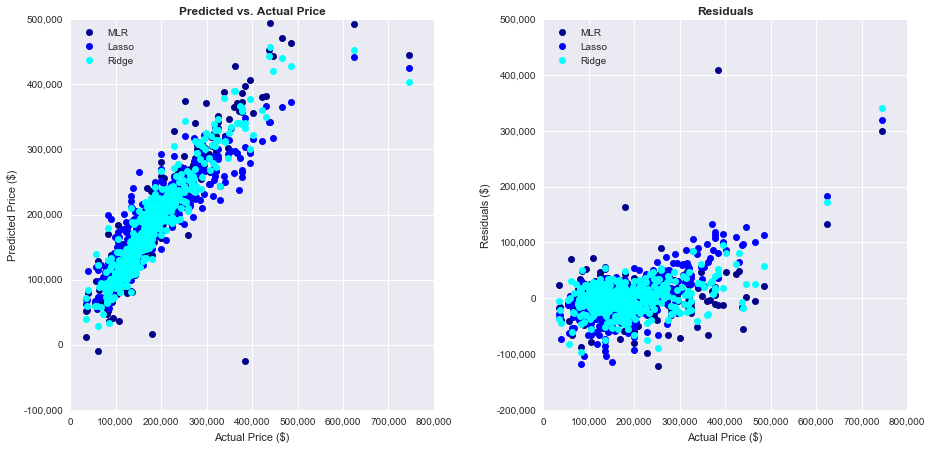

In [8]:
#Model residuals

MLRresiduals_reg = y_test - MLR_predict_reg
lassoResiduals_reg = y_test - lasso_predict_reg
ridgeResiduals_reg = y_test - ridge_predict_reg

# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict_reg,"o",label='MLR', color='darkblue')
ax1.plot(y_test,lasso_predict_reg,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict_reg,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_reg,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals_reg,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_reg,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [9]:
# Try predicting using log SalePrice
log_y_train = y_train.map(float).map(log)
log_y_test = y_test.map(float).map(log)

In [10]:
#Linear Regression
MLR =LinearRegression()
model_MLR_log = MLR.fit(X_train,log_y_train)
MLR_predict_log = model_MLR_log.predict(X_test)
MLR_RMSE_log = sqrt(mean_squared_error(y_test, np.exp(MLR_predict_log)))
print "MLR RMSE:",MLR_RMSE_log

#get best λ with LassoCV
lasso_cv_log = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_log = lasso_cv_log.fit(X_train,ravel(log_y_train))
print "Lasso CV best λ:",model_cv_log.alpha_
lasso_predict_log= model_cv_log.predict(X_test)
lasso_RMSE_log = sqrt(mean_squared_error(y_test, np.exp(lasso_predict_log)))
print "Lasso RMSE:",lasso_RMSE_log

#get best λ with RidgeCV
ridge_cv_log = RidgeCV(cv=10)
ridge_model_cv_log = ridge_cv_log.fit(X_train,ravel(log_y_train))
print "Ridge CV best λ:",ridge_model_cv_log.alpha_
ridge_predict_log = ridge_model_cv_log.predict(X_test)
ridge_RMSE_log = sqrt(mean_squared_error(y_test, np.exp(ridge_predict_log)))
print "Ridge RMSE:",ridge_RMSE_log

MLR RMSE: 26550.4509193
Lasso CV best λ: 1.09577311917
Lasso RMSE: 35654.450704
Ridge CV best λ: 10.0
Ridge RMSE: 27192.5521656


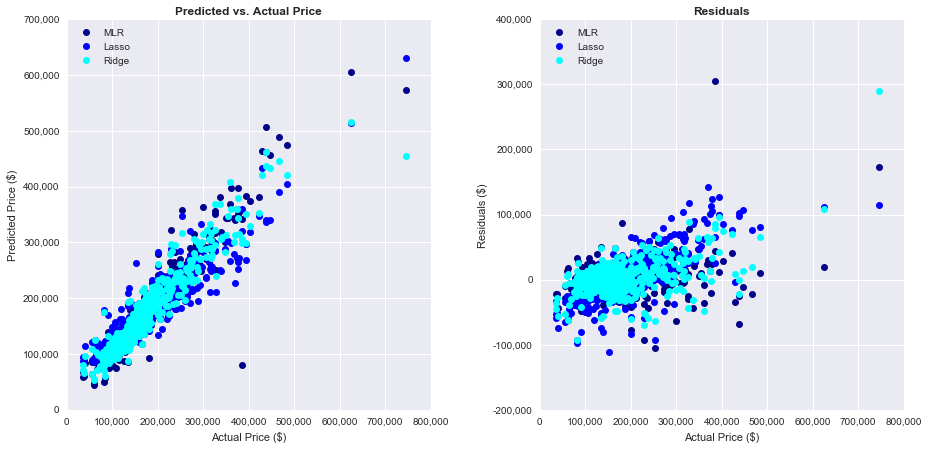

In [11]:
#residuals with log price models (in original scale)
MLRresiduals_log = y_test - np.exp(MLR_predict_log)
lassoResiduals_log = y_test - np.exp(lasso_predict_log)
ridgeResiduals_log = y_test - np.exp(ridge_predict_log)

# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,np.exp(MLR_predict_log),"o",label='MLR',color='darkblue')
ax1.plot(y_test,np.exp(lasso_predict_log),"o",label='Lasso',color='blue')
ax1.plot(y_test,np.exp(ridge_predict_log),"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_log,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals_log,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_log,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [12]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_scaler = StandardScaler()
Y_train_scaled = ravel(y_scaler.fit_transform(y_train.reshape(-1, 1)))
Y_test_scaled = ravel(y_scaler.transform(y_test.reshape(-1, 1)))

/Users/lindsaytober/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [13]:
# Run MLP using different hidden layer sizes
sizes = [(20,),(50,),(100,),(150,),(200,),(250,),(300,)]
RMSEs = []
for size in sizes:
    MLP = MLPRegressor(hidden_layer_sizes = size,activation='tanh',solver='sgd',learning_rate='constant',random_state=42,\
                       batch_size=40,learning_rate_init=0.001)
    model_MLP = MLP.fit(X_train_scaled,Y_train_scaled)
    MLP_predict = model_MLP.predict(X_test_scaled)
    MLP_RMSE= sqrt(mean_squared_error(y_test, y_scaler.inverse_transform(MLP_predict)))
    RMSEs.append(MLP_RMSE)

In [14]:
# Choosing hidden layer size with best RMSE
MLP = MLPRegressor(hidden_layer_sizes = sizes[np.argmin(RMSEs)],activation='tanh',solver='sgd',learning_rate='constant',random_state=42,\
                   batch_size=40,learning_rate_init=0.001)
model_MLP = MLP.fit(X_train_scaled,Y_train_scaled)
MLP_predict_scale = model_MLP.predict(X_test_scaled)
MLP_RMSE_scale = sqrt(mean_squared_error(y_test, y_scaler.inverse_transform(MLP_predict_scale)))
print "MLP RMSE:",MLP_RMSE_scale

MLPresiduals_scale = y_test - y_scaler.inverse_transform(MLP_predict_scale)

MLP RMSE: 36015.4509214


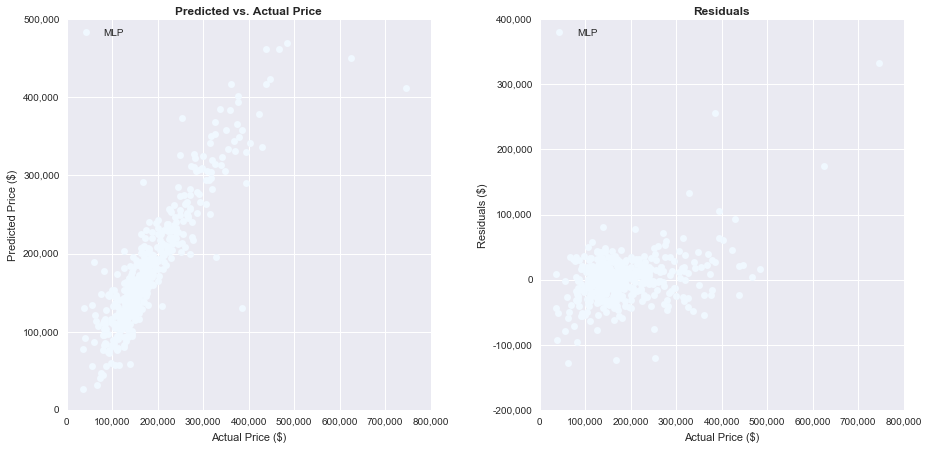

In [15]:
# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,y_scaler.inverse_transform(MLP_predict_scale),"o",label='MLP',color='aliceblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLPresiduals_scale, "o",label='MLP',color='aliceblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [16]:
# Try Linear Regression, Lasso, and Ridge with scaled X data

#Linear Regression
MLR =LinearRegression(fit_intercept=False)
model_MLR_scale = MLR.fit(X_train_scaled,y_train)
MLR_predict_scale = model_MLR_scale.predict(X_test_scaled)
MLR_RMSE_scale= sqrt(mean_squared_error(y_test, MLR_predict_scale))
print "MLR RMSE:",MLR_RMSE_scale

#get best λ with LassoCV
lasso_cv_scale = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_scale = lasso_cv_scale.fit(X_train_scaled,ravel(y_train))
print "Lasso CV best λ:",model_cv_scale.alpha_
lasso_predict_scale = model_cv_scale.predict(X_test_scaled)
lasso_RMSE_scale= sqrt(mean_squared_error(y_test, lasso_predict_scale))
print "Lasso RMSE:",lasso_RMSE_scale

#get best λ with RidgeCV
ridge_cv_scale = RidgeCV(cv=10)
ridge_model_cv_scale = ridge_cv_scale.fit(X_train_scaled,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv_scale.alpha_
ridge_predict_scale= ridge_model_cv_scale.predict(X_test_scaled)
ridge_RMSE_scale= sqrt(mean_squared_error(y_test, ridge_predict_scale))
print "Ridge RMSE:",ridge_RMSE_scale

MLR RMSE: 9.97258863328e+18
Lasso CV best λ: 1695.52642749
Lasso RMSE: 29925.6396206
Ridge CV best λ: 10.0
Ridge RMSE: 34043.6717917


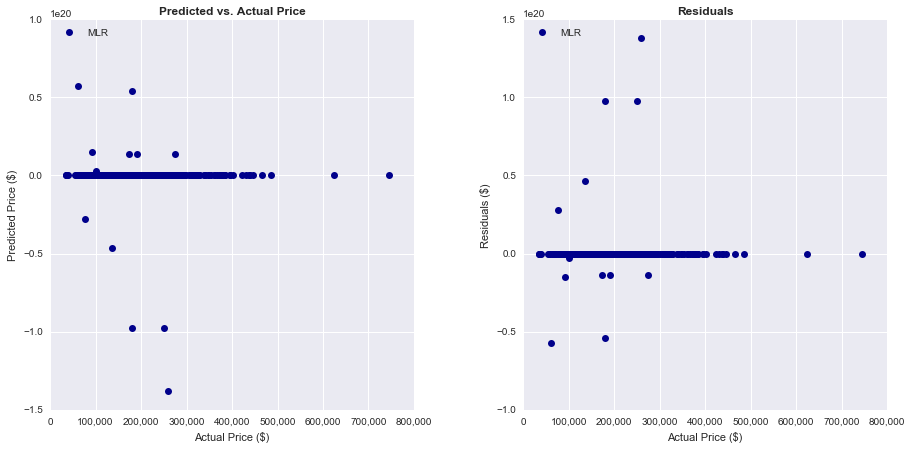

In [17]:
# Based on RMSE, it appears as though MLR may have challenges predicting this data
# For example, the linear regression problem could be under-determined 
#  (where the number of linearly independent rows of the training matrix 
#    is less than its number of linearly independent columns),
#  resulting in erroneous predictions

# Graph to see
MLRresiduals_scale = y_test - MLR_predict_scale
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict_scale,"o",label='MLR',color='darkblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_scale, "o",label='MLR',color='darkblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

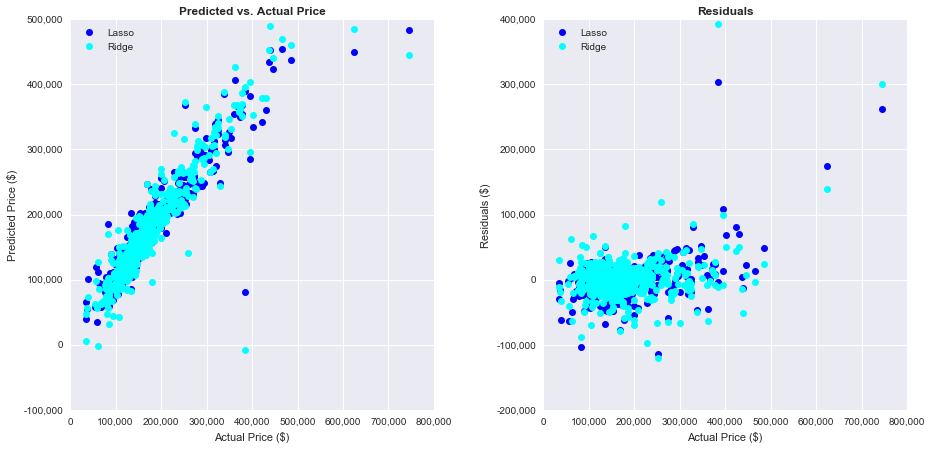

In [18]:
# Plot Lasso and Ridge
lassoResiduals_scale = y_test - lasso_predict_scale
ridgeResiduals_scale = y_test - ridge_predict_scale

fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,lasso_predict_scale,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict_scale,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,lassoResiduals_scale,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_scale,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [19]:
# Try fitting on scaled data and log SalePrice for Lasso and Ridge
#get best λ with LassoCV
lasso_cv_scalelog = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_scalelog = lasso_cv_scalelog.fit(X_train_scaled,ravel(log_y_train))
print "Lasso CV best λ:",model_cv_scalelog.alpha_
lasso_predict_scalelog= model_cv_scalelog.predict(X_test_scaled)
lasso_RMSE_scalelog = sqrt(mean_squared_error(y_test, np.exp(lasso_predict_scalelog)))
print "Lasso RMSE:",lasso_RMSE_scalelog

#get best λ with RidgeCV
ridge_cv_scalelog = RidgeCV(cv=10)
ridge_model_cv_scalelog = ridge_cv_scalelog.fit(X_train_scaled,ravel(log_y_train))
print "Ridge CV best λ:",ridge_model_cv_scalelog.alpha_
ridge_predict_scalelog= ridge_model_cv_scalelog.predict(X_test_scaled)
ridge_RMSE_scalelog = sqrt(mean_squared_error(y_test, np.exp(ridge_predict_scalelog)))
print "Ridge RMSE:",ridge_RMSE_scalelog

Lasso CV best λ: 0.00617476647261
Lasso RMSE: 23872.9408725
Ridge CV best λ: 10.0
Ridge RMSE: 26622.3843697


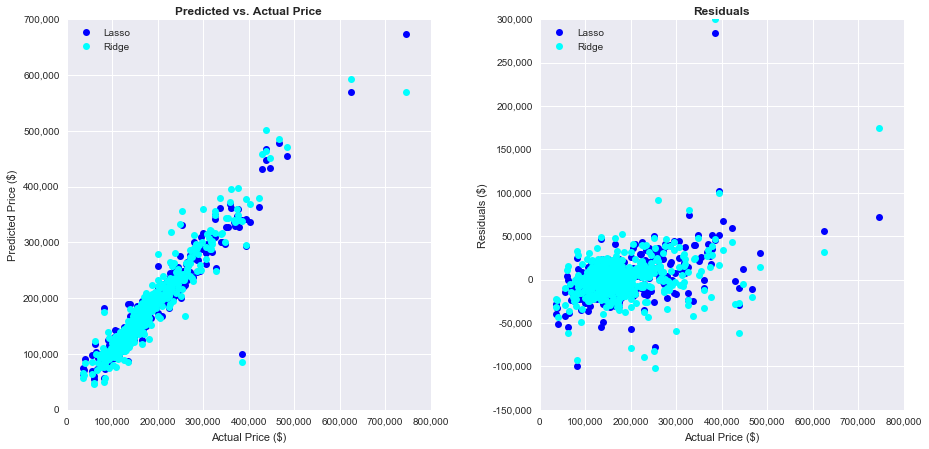

In [20]:
# Plot Lasso and Ridge results for scaled X data / log SalePrice
lassoResiduals_scalelog = y_test - np.exp(lasso_predict_scalelog)
ridgeResiduals_scalelog = y_test - np.exp(ridge_predict_scalelog)

fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,np.exp(lasso_predict_scalelog),"o",label='Lasso',color='blue')
ax1.plot(y_test,np.exp(ridge_predict_scalelog),"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,lassoResiduals_scalelog,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_scalelog,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

### SVR

In [ ]:
SVR_reg = SVR(kernel='linear', C=10)
SVR_reg.fit(X_train,y_train)
SVR_predict_reg=SVR_reg.predict(X_test)
SVR_RMSE_reg=np.sqrt(mean_squared_error(y_test,SVR_predict_reg))
SVR_RMSE_reg

In [ ]:
SVR_scale = SVR(kernel='linear', C=10)
SVR_scale.fit(X_train_scaled,y_train)
SVR_predict_scale=SVR_scale.predict(X_test_scaled)
SVR_RMSE_scale=np.sqrt(mean_squared_error(y_test,SVR_predict_scale))
SVR_RMSE_scale

In [ ]:
SVR_log = SVR(kernel='linear', C=10)
SVR_log.fit(X_train,ravel(log_y_train))
SVR_predict_log=SVR_log.predict(X_test)
SVR_RMSE_log=np.sqrt(mean_squared_error(y_test,np.exp(SVR_predict_log)))
SVR_RMSE_log

In [ ]:
SVR_scalelog = SVR(kernel='linear', C=10)
SVR_scalelog.fit(X_train_scaled,ravel(log_y_train))
SVR_predict_scalelog=SVR_scalelog.predict(X_test_scaled)
SVR_RMSE_scalelog=np.sqrt(mean_squared_error(y_test,np.exp(SVR_predict_scalelog)))
SVR_RMSE_scalelog

### SGD Regressor

In [ ]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'learning_rate': ['optimal','invscaling','constant']}
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_reg = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_reg.fit(X_train, y_train) 

In [ ]:
print SGDclf_reg.best_params_
print SGDclf_reg.best_score_

In [ ]:
GSCV_SGDclf_reg = SGDRegressor(loss='huber', penalty='l2', alpha=0.001, random_state=42)
GSCV_SGDclf_reg.fit(X_train, y_train)
GSCV_SGDclf_predict_reg = GSCV_SGDclf_reg.predict(X_test)
GSCV_SGDclf_RMSE_reg=np.sqrt(mean_squared_error(y_test, GSCV_SGDclf_predict_reg))
GSCV_SGDclf_RMSE_reg

In [ ]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'alpha': [0.01, 0.001, 0.0001]
             }
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_scale = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_scale.fit(X_train_scaled, y_train)

In [ ]:
print SGDclf_scale.best_params_
print SGDclf_scale.best_score_

In [ ]:
GSCV_SGDclf_scale = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
GSCV_SGDclf_scale.fit(X_train_scaled, y_train)
GSCV_SGDclf_predict_scale = GSCV_SGDclf_scale.predict(X_test_scaled)
GSCV_SGDclf_RMSE_scale=np.sqrt(mean_squared_error(y_test, GSCV_SGDclf_predict_scale))
GSCV_SGDclf_RMSE_scale

In [ ]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'alpha': [0.01, 0.001, 0.0001]
             }
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_log = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_log.fit(X_train, log_y_train)

In [ ]:
print SGDclf_log.best_params_
print SGDclf_log.best_score_

In [ ]:
### NOT SURE OF BEST PARAMS -- LOG WOULDN'T RUN
# GSCV_SGDclf_log = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
# GSCV_SGDclf_log.fit(X_train, log_y_train)
# GSCV_SGDclf_predict_log = GSCV_SGDclf_log.predict(X_test)
# GSCV_SGDclf_RMSE_log=np.sqrt(mean_squared_error(y_test, np.exp(GSCV_SGDclf_predict_log)))
# GSCV_SGDclf_RMSE_log

In [ ]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'alpha': [0.01, 0.001, 0.0001]
             }
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_scalelog = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_scalelog.fit(X_train_scaled, log_y_train)

In [ ]:
print SGDclf_scalelog.best_params_
print SGDclf_scalelog.best_score_

In [ ]:
### NOT SURE OF BEST PARAMS -- LOG WOULDN'T RUN
# GSCV_SGDclf_scalelog = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
# GSCV_SGDclf_scalelog.fit(X_train_scaled, log_y_train)
# GSCV_SGDclf_predict_scalelog = GSCV_SGDclf_scalelog.predict(X_test_scaled)
# GSCV_SGDclf_RMSE_scalelog=np.sqrt(mean_squared_error(y_test, np.exp(GSCV_SGDclf_predict_scalelog)))
# GSCV_SGDclf_RMSE_scalelog

### Regression Trees

In [ ]:
# Create and fit the model
model_tree2_reg = DecisionTreeRegressor(random_state = 1)
model_tree2_reg.fit(X_train, y_train)

# Predict on the test set
p_tree2_reg = model_tree2_reg.predict(X_test)

# Calculate RMSE of the model
REGTREE_residuals_reg = p_tree2_reg - y_test
REGTREE_MSE_reg = (REGTREE_residuals_reg**2).mean()
REGTREE_RMSE_reg = math.sqrt(REGTREE_MSE_reg)

print "RMSE for Regression Tree is:", round(REGTREE_RMSE_reg,4)

In [ ]:
# Create and fit the model
model_tree2_log = DecisionTreeRegressor(random_state = 1)
model_tree2_log.fit(X_train, log_y_train)

# Predict on the test set
p_tree2_log = model_tree2_log.predict(X_test)

# Calculate RMSE of the model
REGTREE_residuals_log = np.exp(p_tree2_log) - y_test
REGTREE_MSE_log = (REGTREE_residuals_log**2).mean()
REGTREE_RMSE_log = math.sqrt(REGTREE_MSE_log)

print "RMSE for Regression Tree USING LOG is:", round(REGTREE_RMSE_log,4)

In [ ]:
# Create and fit the model
model_tree2_scale = DecisionTreeRegressor(random_state = 1)
model_tree2_scale.fit(X_train_scaled, y_train)

# Predict on the test set
p_tree2_scale = model_tree2_scale.predict(X_test_scaled)

# Calculate RMSE of the model
REGTREE_residuals_scale = p_tree2_scale - y_test
REGTREE_MSE_scale = (REGTREE_residuals_scale**2).mean()
REGTREE_RMSE_scale = math.sqrt(REGTREE_MSE_scale)

print "RMSE with scaling Regression Tree is:", round(REGTREE_RMSE_scale,4)

In [ ]:
# Create and fit the model
model_tree2_scalelog = DecisionTreeRegressor(random_state = 1)
model_tree2_scalelog.fit(X_train_scaled, log_y_train)

# Predict on the test set
p_tree2_scalelog = model_tree2_scalelog.predict(X_test_scaled)

# Calculate RMSE of the model
REGTREE_residuals_scalelog = np.exp(p_tree2) - y_test
REGTREE_MSE_scalelog = (REGTREE_residuals_scalelog**2).mean()
REGTREE_RMSE_scalelog = math.sqrt(REGTREE_MSE_scalelog)

print "RMSE with scaling for Regression Tree USING LOG is:", round(REGTREE_RMSE_scalelog,4)

In [ ]:
# # Feature importances from Model 1
# imp_tree1 = pd.Series(model_tree1.feature_importances_,X_train.columns.values)
# print imp_tree1.sort_values(ascending = False)[:10]

# Feature importances from Model 2
imp_tree2 = pd.Series(model_tree2_reg.feature_importances_,X_train.columns.values)
print imp_tree2.sort_values(ascending = False)[:10]

In [ ]:
# SUMMARY - Regression Trees
print "RMSE for Regression Tree is:", round(REGTREE_RMSE_reg,4)
print "RMSE for Regression Tree USING LOG is:", round(REGTREE_RMSE_log,4)
print "RMSE with scaling Regression Tree is:", round(REGTREE_RMSE_scale,4)
print "RMSE with scaling for Regression Tree USING LOG is:", round(REGTREE_RMSE_scalelog,4)

###  Random Forest (GridSearchCV)

In [ ]:
# Cross validate RF model
# Set parameter dictionary to search through
params = {'n_estimators':[10,100,500, 1000], 'max_depth':[5,10,20]}

# Create model and fit best parameters
model_rf2 = RandomForestRegressor()
model_rf2_GS_reg = GridSearchCV(model_rf2, params)
model_rf2_GS_log = GridSearchCV(model_rf2, params)
model_rf2_GS_scale = GridSearchCV(model_rf2, params)
model_rf2_GS_scalelog = GridSearchCV(model_rf2, params)

In [ ]:
# Avoid running, build a RF model below
model_rf2_GS_reg.fit(X_train, y_train)

In [ ]:
# Avoid running, build a RF model below
model_rf2_GS_log.fit(X_train, log_y_train)

In [ ]:
# Avoid running, build a RF model below
model_rf2_GS_scale.fit(X_train_scaled, y_train)

In [ ]:
# Avoid running, build a RF model below
model_rf2_GS_scalelog.fit(X_train_scaled, log_y_train)

In [ ]:
# Save best estimates to avoid re-running grid search
model_rf2_GS_reg_best=model_rf2_GS_reg.best_estimator_
model_rf2_GS_log_best=model_rf2_GS_log.best_estimator_
model_rf2_GS_scale_best=model_rf2_GS_scale.best_estimator_
model_rf2_GS_scalelog_best=model_rf2_GS_scalelog.best_estimator_

In [ ]:
# Make predictions on Grid search optimized RF model
p_rf2_reg = model_rf2_GS_reg.predict(X_test)

# Calculate RMSE of the model
GS_RANDFOR_residuals_reg = p_rf2_reg - y_test
GS_RANDFOR_MSE_reg = (GS_RANDFOR_residuals_reg**2).mean()
GS_RANDFOR_RMSE_reg = math.sqrt(GS_RANDFOR_MSE_reg)

print "RMSE for GS Random Forest is:", round(GS_RANDFOR_RMSE_reg,4)

In [ ]:
# Make predictions on Grid search optimized RF model
p_rf2_log = model_rf2_GS_log.predict(X_test)

# Calculate RMSE of the model
GS_RANDFOR_residuals_log = np.exp(p_rf2_log) - y_test
GS_RANDFOR_MSE_log = (GS_RANDFOR_residuals_log**2).mean()
GS_RANDFOR_RMSE_log = math.sqrt(GS_RANDFOR_MSE_log)

print "RMSE for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_log,4)

In [ ]:
# Make predictions on Grid search optimized RF model
p_rf2_scale = model_rf2_GS_scale.predict(X_test_scaled)

# Calculate RMSE of the model
GS_RANDFOR_residuals_scale = p_rf2_scale - y_test
GS_RANDFOR_MSE_scale = (GS_RANDFOR_residuals_scale**2).mean()
GS_RANDFOR_RMSE_scale = math.sqrt(GS_RANDFOR_MSE_scale)

print "RMSE using scaling for GS Random Forest is:", round(GS_RANDFOR_RMSE_scale,4)

In [ ]:
# Make predictions on Grid search optimized RF model
p_rf2_scalelog = model_rf2_GS_scalelog.predict(X_test_scaled)

# Calculate RMSE of the model
GS_RANDFOR_residuals_scalelog = np.exp(p_rf2_scalelog) - y_test
GS_RANDFOR_MSE_scalelog = (GS_RANDFOR_residuals_scalelog**2).mean()
GS_RANDFOR_RMSE_scalelog = math.sqrt(GS_RANDFOR_MSE_scalelog)

print "RMSE using scaling for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_scalelog,4)

In [ ]:
# SUMMARY - GridsearchCV on Random Forests
print "RMSE for GS Random Forest is:", round(GS_RANDFOR_RMSE_reg,4)
print "RMSE for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_log,4)
print "RMSE using scaling for GS Random Forest is:", round(GS_RANDFOR_RMSE_scale,4)
print "RMSE using scaling for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_scalelog,4)

### Gradient Boosting (GridSearchCV)

In [ ]:
# Create Gradient Boosting Model
model_gb1 = GradientBoostingRegressor()

# Create parameter dictionary for GridSearchCV
params = {'n_estimators':(5,10,50,100,500,1000),'learning_rate':(0.01, 0.05, 0.1, 0.2)}

#Create Grid Search Model
model_gb1_GS = GridSearchCV(model_gb1,params)
model_gb1_GS_reg = GridSearchCV(model_gb1, params)
model_gb1_GS_log = GridSearchCV(model_gb1, params)
model_gb1_GS_scale = GridSearchCV(model_gb1, params)
model_gb1_GS_scalelog = GridSearchCV(model_gb1, params)

In [ ]:
# Avoid running, build a RF model below
model_gb1_GS_reg.fit(X_train, y_train)

In [ ]:
# Avoid running, build a RF model below
model_gb1_GS_log.fit(X_train, log_y_train)

In [ ]:
# Avoid running, build a RF model below
model_gb1_GS_scale.fit(X_train_scaled, y_train)

In [ ]:
# Avoid running, build a RF model below
model_gb1_GS_scalelog.fit(X_train_scaled, log_y_train)

In [ ]:
# Save best estimates to avoid re-running grid search
model_gb1_GS_reg_best=model_gb1_GS_reg.best_estimator_
model_gb1_GS_log_best=model_gb1_GS_log.best_estimator_
model_gb1_GS_scale_best=model_gb1_GS_scale.best_estimator_
model_gb1_GS_scalelog_best=model_gb1_GS_scalelog.best_estimator_

In [ ]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_reg = model_gb1_GS_reg.predict(X_test)

# Calculate RMSE of the model
GS_GRADBOOST_residuals_reg = p_gb1_reg - y_test
GS_GRADBOOST_MSE_reg = (GS_GRADBOOST_residuals_reg**2).mean()
GS_GRADBOOST_RMSE_reg = math.sqrt(GS_GRADBOOST_MSE_reg)

print "RMSE for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_reg,4)

In [ ]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_log = model_gb1_GS_log.predict(X_test)

# Calculate RMSE of the model
GS_GRADBOOST_residuals_log = np.exp(p_gb1_log) - y_test
GS_GRADBOOST_MSE_log = (GS_GRADBOOST_residuals_log**2).mean()
GS_GRADBOOST_RMSE_log = math.sqrt(GS_GRADBOOST_MSE_log)

print "RMSE for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_log,4)

In [ ]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_scale = model_gb1_GS_scale.predict(X_test_scaled)

# Calculate RMSE of the model
GS_GRADBOOST_residuals_scale = p_gb1_scale - y_test
GS_GRADBOOST_MSE_scale = (GS_GRADBOOST_residuals_scale**2).mean()
GS_GRADBOOST_RMSE_scale = math.sqrt(GS_GRADBOOST_MSE_scale)

print "RMSE with scaling for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_scale,4)

In [ ]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_scalelog = model_gb1_GS_scalelog.predict(X_test_scaled)

# Calculate RMSE of the model
GS_GRADBOOST_residuals_scalelog = np.exp(p_gb1_scalelog) - y_test
GS_GRADBOOST_MSE_scalelog = (GS_GRADBOOST_residuals_scalelog**2).mean()
GS_GRADBOOST_RMSE_scalelog = math.sqrt(GS_GRADBOOST_MSE_scalelog)

print "RMSE with scaling for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_scalelog,4)

In [ ]:
# SUMMARY - GridsearchCV on Gradient Boosting
print "RMSE for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_reg,4)
print "RMSE for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_log,4)
print "RMSE with scaling for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_scale,4)
print "RMSE with scaling for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_scalelog,4)

### AdaBoost

In [ ]:
#predictions are on average 1.17 times as large as the actual value
parameters={'learning_rate': [0.01, 0.001, 0.0001], 'loss': ['linear', 'square']}
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
GS_ADABOOST = GridSearchCV(AdaBoostRegressor(random_state=0), parameters, cv=5,scoring=accuracy)
GS_ADABOOST.fit(X_train, y_train)

In [ ]:
GS_ADABOOST.best_params_

In [ ]:
GS_ADABOOST_reg=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_reg.fit(X_train, y_train)
GS_ADABOOST_predict_reg=GS_ADABOOST_reg.predict(X_test)
GS_ADABOOST_RMSE_reg=np.sqrt(np.mean((y_test-GS_ADABOOST_predict_reg)**2))
GS_ADABOOST_RMSE_reg

In [ ]:
GS_ADABOOST_scale=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_scale.fit(X_train_scaled, y_train)
GS_ADABOOST_predict_scale = GS_ADABOOST_scale.predict(X_test_scaled)
GS_ADABOOST_RMSE_scale=np.sqrt(np.mean((y_test-GS_ADABOOST_predict_scale)**2))
GS_ADABOOST_RMSE_scale

In [ ]:
GS_ADABOOST_log=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_log.fit(X_train, log_y_train)
GS_ADABOOST_predict_log = GS_ADABOOST_log.predict(X_test)
GS_ADABOOST_RMSE_log=np.sqrt(np.mean((y_test-np.exp(GS_ADABOOST_predict_log))**2))
GS_ADABOOST_RMSE_log

In [ ]:
GS_ADABOOST_scalelog=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_scalelog.fit(X_train_scaled, log_y_train)
GS_ADABOOST_predict_scalelog = GS_ADABOOST_scalelog.predict(X_test_scaled)
GS_ADABOOST_RMSE_scalelog=np.sqrt(np.mean((y_test-np.exp(GS_ADABOOST_predict_scalelog))**2))
GS_ADABOOST_RMSE_scalelog

### MARS

In [ ]:
# Best Model
MARS_scalelog = Earth(max_degree= 3,penalty=2.0,feature_importance_type = "rss",
                      smooth=True,enable_pruning=True)

MARS_scalelog_fit = MARS_scalelog.fit(X_train_scaled,log_y_train)

In [ ]:
# Model Summary
print MARS_scalelog_fit.summary()
print MARS_scalelog_fit.summary_feature_importances(sort_by = 'rss')

In [ ]:
MARS_predict_scalelog = MARS_scalelog_fit.predict(X_test_scaled)

MARS_RMSE_scalelog = np.sqrt(mean_squared_error(y_test,np.exp(MARS_predict_scalelog)))
print "The rmse for MARS is", MARS_RMSE_scalelog

## MODEL COMPARISONS

In [ ]:
models=['MLR','lasso','ridge','MLP','SVR','GSCV_SGDclf','MARS','REGTREE',
        'GS_ADABOOST','GS_GRADBOOST','GS_RANDFOR']
modelnames=['MLR','Lasso','Ridge','MLP','SVR','SGD Regression','MARS','Regression Tree',
            'Ada Boosting','Gradient Boost','Random Forest']
versions=['reg','log','scale','scalelog']
versionnames=['All Predictors','Log Price','Scaled Predictors','Scaled Predictors+LogPrice']
RMSEsummary_dict={}

for model in models:
    for version in versions:
        try:
            RMSE=eval(model+'_RMSE_'+version)
        except:
            RMSE='--'
        if version in RMSEsummary_dict.keys():
            RMSEsummary_dict[version].append(RMSE)
        else:
            RMSEsummary_dict[version]=[RMSE]


RMSEsummary=pd.DataFrame(RMSEsummary_dict,index=modelnames)
RMSEsummary=RMSEsummary.rename(columns=dict(zip(versions,versionnames)))
RMSEsummary=RMSEsummary[versionnames]
RMSEsummary

In [ ]:
# Best Residuals
BMresiduals_GRADBOOST_scale=GS_GRADBOOST_residuals_scale
BMresiduals_MARS_scalelog=y_test-np.exp(MARS_predict_scalelog)
BMresiduals_LASSO_scalelog=lassoResiduals_scalelog

# Worst Residuals
WMresiduals_SVR_scale=y_test-SVR_predict_scale
WMresiduals_ADABOOST_log=y_test-np.exp(GS_ADABOOST_predict_log)
WMresiduals_SGD_reg=y_test-GSCV_SGDclf_predict_reg

In [ ]:
# Plot Residuals - Best Models
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.plot(y_test,BMresiduals_LASSO_scalelog,"o",label='Lasso',color='palegreen')
ax1.plot(y_test,BMresiduals_MARS_scalelog['Residuals'],"o",label='MARS',color='mediumspringgreen')
ax1.plot(y_test,BMresiduals_GRADBOOST_scale,"o",label='GradientBoost', color='darkgreen')
ax1.legend(numpoints=1,loc='upper right')
ax1.set_ylabel('Residuals ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_ylim([-200000,500000])
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Residuals', fontsize=12, fontweight='bold')

In [ ]:
# Plot Residuals - Worst Models
fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(121)
ax2.plot(y_test,WMresiduals_SVR_scale,"o",label='SVR',color='palevioletred')
ax2.plot(y_test,WMresiduals_SGD_reg,"o",label='SGD Regression',color='red')
ax2.plot(y_test,WMresiduals_ADABOOST_log,"o",label='AdaBoost', color='darkred')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

## CLUSTERING

In [ ]:
# Consolidate train data for clustering purposes
X_train_cluster = X_train.copy()
train_data_cluster = X_train_cluster.copy()
train_data_cluster['SalePrice'] = y_train
# Consolidate train data for graphing purposes
train_data = train_data_cluster.copy()
# train_data['Id'] = X_train['Id']

In [ ]:
# Fit model with 5 clusters
KMmodel_5 = KMeans(n_clusters=5, random_state=1)
KMfit_5 = KMmodel_5.fit(train_data_cluster)

In [ ]:
# Fit model with 5 clusters on X variables
KMmodel_5x = KMeans(n_clusters=5, random_state=1)
KMfit_5x = KMmodel_5x.fit(X_train_cluster)

In [ ]:
# Check for delineation across home prices purely based on cluster when price is included
scatter(train_data.index,train_data['SalePrice'],c=KMfit_5.labels_, cmap='ocean')


In [ ]:
# Check for delineation across home prices purely based on cluster when price is excluded
scatter(train_data.index,train_data['SalePrice'],c=KMfit_5x.labels_, cmap='ocean')

In [ ]:
# Compare labels
scatter(KMfit_5x.labels_,KMfit_5.labels_)

In [ ]:
# Get correlation of each column with both labels
correlation_dict={}
for column in train_data.columns.values:
    xcor=corrcoef(train_data[column],KMfit_5x.labels_)[0][1]
    totcor=corrcoef(train_data[column],KMfit_5.labels_)[0][1]
    correlation_dict[column]=[xcor,totcor]

In [ ]:
# Put correlations into a dataframe
col1=correlation_dict.keys()
col2=[val[0] for val in correlation_dict.values()]
col3=[val[1] for val in correlation_dict.values()]
correlation_df=pd.DataFrame({'1_Column':col1,'2_X Corr':col2,'3_All Corr':col3})
correlation_df.head()

In [ ]:
# View 'best predictors' through sale price for correlation using all variables
bestpredictor_df=correlation_df.sort_values('3_All Corr',ascending=False).copy()
bestpredictor_df=bestpredictor_df.reset_index()
bestpredictor_df=bestpredictor_df.drop('index',1)
# All predictors up through saleprice
bestpredictor_df[:27]

In [ ]:
# Create new X matrix with just these columns
X_cluster = X_train.ix[:,:1].copy()
for colname in bestpredictor_df['1_Column'][:26]:
    X_cluster[colname]=X_train[colname]
X_cluster=X_cluster.drop('Id',1)
X_cluster.head()

In [ ]:
# Fit model with 5 clusters on X cluster data
KMmodel_5xc = KMeans(n_clusters=5, random_state=1)
KMfit_5xc = KMmodel_5xc.fit(X_cluster)

In [ ]:
# Prepare cluster data for graphing
cluster_data=X_cluster.copy()
cluster_data['Id']=X_train['Id']
cluster_data['SalePrice']=y_train

In [ ]:
# Check for delineation across home prices purely based on cluster using cluster data when price is excluded
scatter(cluster_data['Id'],cluster_data['SalePrice'],c=KMfit_5xc.labels_, cmap='ocean')

In [ ]:
# Get top and bottom indicators for each cluster
# where 'top' is biggest number (i.e., largest and/or most postive)
# and 'bottome' is smallest number (i.e., smallest and/or most negative)
keyindicators_dict={}
centercounter=0
for center in KMfit_5.cluster_centers_:
    label=list(set(KMfit_5.labels_))[centercounter]
    top5indices=np.argpartition(center,-5)[-5:]
    top5=list(train_data.columns.values[top5indices])
    top10indices=np.argpartition(center,-10)[-10:]
    top10=list(train_data.columns.values[top10indices])
    bottom5indices=np.argpartition(center,5)[:5]
    bottom5=list(train_data.columns.values[bottom5indices])
    bottom10indices=np.argpartition(center,10)[:10]
    bottom10=list(train_data.columns.values[bottom10indices])
    keyindicators_dict[label]=[top5,top10,bottom5,bottom10]
    centercounter+=1

In [ ]:
# Get all indicators in top10s
top10lists=[val[1] for val in keyindicators_dict.values()]
uniquetop10=list(set([j for i in top10lists for j in i]))
uniquetop10

In [ ]:
# Get all indicators in bottom10s
bottom10lists=[val[3] for val in keyindicators_dict.values()]
uniquebottom10=list(set([j for i in bottom10lists for j in i]))
uniquebottom10

In [ ]:
# Design matrix of top10
X_top10 = X_train.ix[:,:1].copy()
for colname in uniquetop10:
    try:
        X_top10[colname]=X_train[colname]
    except:
        pass # SalePrice
X_top10=X_top10.drop('Id',1)
X_top10.head()

In [ ]:
# Fit model with 5 clusters on top10
KMmodel_5xt10 = KMeans(n_clusters=5, random_state=1)
KMfit_5xt10 = KMmodel_5xt10.fit(X_top10)

In [ ]:
# Prepare cluster data for graphing
top10_data=X_top10.copy()
top10_data['Id']=X_train['Id']
top10_data['SalePrice']=y_train

In [ ]:
# Check for delineation across home prices purely based on cluster using cluster data when price is excluded
scatter(top10_data['Id'],top10_data['SalePrice'],c=KMfit_5xt10.labels_, cmap='ocean')

In [ ]:
# Let's run models just to test...need test data first
X_top10_test = X_test.ix[:,:1].copy()
for colname in uniquetop10:
    try:
        X_top10_test[colname]=X_test[colname]
    except:
        pass # SalePrice
X_top10_test=X_top10_test.drop('Id',1)
X_top10_test.head()

In [ ]:
# Fit model with 5 clusters on top10 for test data
KMmodel_5xt10test = KMeans(n_clusters=5, random_state=1)
KMfit_5xt10test = KMmodel_5xt10test.fit(X_top10_test)

In [ ]:
X_top10['Cluster']=KMfit_5xt10.labels_
X_top10_test['Cluster']=KMfit_5xt10test.labels_

In [ ]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_top10,y_train)
MLR_predict = model_MLR.predict(X_top10_test)
MLR_RMSE= sqrt(mean_squared_error(y_test, MLR_predict))
print "MLR RMSE:",MLR_RMSE

#get best λ with LassoCV
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv = lasso_cv.fit(X_top10,ravel(y_train))
print "Lasso CV best λ:",model_cv.alpha_

#Lasso
lasso= Lasso(alpha=model_cv.alpha_)
model_lasso= lasso.fit(X_top10,y_train)
lasso_predict= model_lasso.predict(X_top10_test)
lasso_RMSE= sqrt(mean_squared_error(y_test, lasso_predict))
print "Lasso RMSE:",lasso_RMSE

#get best λ with RidgeCV
ridge_cv = RidgeCV(cv=10)
ridge_model_cv = ridge_cv.fit(X_top10,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv.alpha_

#Ridge
ridge= Ridge(alpha=ridge_model_cv.alpha_)
model_ridge= ridge.fit(X_top10,y_train)
ridge_predict= model_ridge.predict(X_top10_test)
ridge_RMSE= sqrt(mean_squared_error(y_test, ridge_predict))
print "Ridge RMSE:",ridge_RMSE

In [ ]:
# Not great...
# But let's see if the errors are in different places...

MLRresiduals = y_test - MLR_predict
lassoResiduals = y_test - lasso_predict
ridgeResiduals = y_test - ridge_predict

# Plot
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict,"o",label='MLR', color='darkblue')
ax1.plot(y_test,lasso_predict,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict,"o",label='Ridge',color='lightblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals,"o",label='Ridge',color='lightblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [ ]:
Counter(list(KMfit_5x.labels_))

In [ ]:
#cross-validating to find best number of clusters
k_range = range(1,14)
k_means_var = [KMeans(n_clusters=k).fit(X_train_cluster) for k in k_range]
centroids = [c.cluster_centers_ for c in k_means_var]
euclid = [cdist(X_train_cluster,cent,'euclidean') for cent in centroids]
dist = [np.min(ke,axis=1) for ke in euclid]

#within cluster ss
wcss = [sum(d**2) for d in dist]

#total cluster ss
tss = sum(pdist(X_train_cluster)**2)/X_train_cluster.shape[0]

#between cluster ss
bss = tss - wcss

#elbow curve to identify best k (number of clusters)
plt.plot(bss)
plt.xlabel('k number of clusters')
plt.ylabel('Between Cluster Sum of Squares')


In [ ]:
# Fit model with 5 clusters on X variables
KMmodel_4x = KMeans(n_clusters=4, random_state=1)
KModel_fit= KMmodel_4x.fit_predict(X_train_cluster)
scatter(train_data.index,train_data['SalePrice'],c=KModel_fit, cmap='ocean')


In [ ]:
Counter(list(KModel_fit))
# len(X_train_cluster)

In [ ]:
X_train_cluster= X_train_cluster.reset_index(drop=True)
X_train_cluster['cluster'] = pd.Series(KModel_fit)

In [ ]:
X_test_cluster = X_test.copy()
X_test_cluster= X_test_cluster.reset_index(drop=True)
KMmodel_4x_pred = KMmodel_4x.predict(X_test_cluster)
X_test_cluster['cluster'] = pd.Series(KMmodel_4x_pred)

In [ ]:
pd.Series(KMmodel_4x_pred).value_counts()

In [ ]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_train_cluster,y_train)
MLR_predict = model_MLR.predict(X_test_cluster)
MLR_RMSE= sqrt(mean_squared_error(y_test, MLR_predict))
print "MLR RMSE:",MLR_RMSE

#get best λ with LassoCV
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv = lasso_cv.fit(X_train_cluster,ravel(y_train))
print "Lasso CV best λ:",model_cv.alpha_
lasso_predict= model_cv.predict(X_test_cluster)
lasso_RMSE= sqrt(mean_squared_error(y_test, lasso_predict))
print "Lasso RMSE:",lasso_RMSE

#get best λ with RidgeCV
ridge_cv = RidgeCV(cv=10)
ridge_model_cv = ridge_cv.fit(X_train_cluster,ravel(y_train))
print "Ridge CV best λ:",ridge_model_cv.alpha_
ridge_predict= ridge_model_cv.predict(X_test_cluster)
ridge_RMSE= sqrt(mean_squared_error(y_test, ridge_predict))
print "Ridge RMSE:",ridge_RMSE